In [141]:
# author : Myron Kukhta (xkukht01)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

3.8.0


In [142]:
class SLR():
    '''
    
    Class for implamintation of Simple Linear Regression (SLR)

    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to data with positive relation
            PATH_DO_NEGATIVE_DATASET [str]: relative path to data with positive relation
            _dataset [pd.DataFrame]: dataframe with positive relations dataset
            _negative_dataset [pd.DataFrame]: dataframe with negative relations dataset
            _solv [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solv = pd.DataFrame(columns=['cnt', 'Real Y', 'Predict Y', 'B1', 'B2', 'Sum of E', 'R'])


    def StoringDataSet(self)->None:
        '''
        
        Storing dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = os.path.join(os.getcwd(), self.PATH_TO_DATASET)
        
        if not os.path.isfile(path):  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')
        
        self._is_stored_dataset = True


    def _Check_dataset(self)->bool:
        '''

        Description:
            Datasets should not be empty
        
        '''
        if self._dataset.empty:
            return False

        return True

    def _Get_dataset(self, positive:bool)->pd.DataFrame:
        '''
        
        Description: 
            Give dataset for experiment

        '''
        return self._dataset

    def _Sampling(self, data:pd.DataFrame, full_dataset:bool, random_sampling:bool, cnt_sample:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            data [pd.DataFrame]: dataframe to sampling
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample  [bool]: items number in sample

        '''
        sample = data.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 100)
        else:
            cnt_samples = cnt_sample
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: prdicted dependet data
        
        '''
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, int, float, int, int, np.array, float, float]:
        '''

        Description:
            Core of SLR
        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data

        '''

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        b2 = np.sum(np.multiply((x - x_mean), (y - y_mean)))/np.sum(np.power((x - x_mean), 2))
        b1 = y_mean - b2*x_mean

        y_predict = b1 + b2*x

        e = y - y_predict  # positive (up), negative (down)

        e_sum = np.sum(e)
        y_sum = np.sum(y)
        y_predict_sum = np.sum(y_predict)

        r = (np.mean(np.multiply(x, y)) - np.mean(x)*np.mean(y))/np.sqrt((np.mean(np.power(x,2))-np.mean(x)**2)*(np.mean(np.power(y,2))-np.mean(y)**2))

        return y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r
        
    def Dataset(self, positive:bool):
        '''
        
        Description:
            Dataset on output
        
        Parametrs:
            positive [bool]: dataset with positive relation
        
        '''
        print(self._Get_dataset(positive))

    def Theoretical_part(self):
        pass
    
    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, positive:bool, cnt_sample:int, viz_with_err:bool)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            positive [bool]: data from dataset with positive/negative relation
            cnt_sample [int]: items number in sample

        '''
        self._solv.drop(self._solv.index,inplace=True)
        
        if count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            count = 1

        if not self._Check_dataset():  # check data storing
            raise Exception('Warning! You have empty datasets. Please store a data')
        
        for _ in range(count):  # repetitions

            x, y, = self._Sampling(self._Get_dataset(positive), full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r = self._Alg(x, y)  # SLR
            
            self._solv.loc[len(self._solv)] = {'cnt':x.size, 'Real Y':y_sum, 'Predict Y':y_predict_sum, 'B1': b1, 'B2': b2, 'Sum of E':e_sum, 'R': r}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)


        print(self._solv)

    

In [143]:
# Prolog

SLR_solv = SLR()
SLR_solv.Theoretical_part()


In [144]:
# Prepare data

SLR_solv.StoringDataSet()

SLR_solv.Dataset(positive=True)

      Unnamed: 0  price  totsp  livesp  kitsp  dist  metrdist  walk  brick  \
0              1     81     58      40    6.0  12.5         7     1      1   
1              2     75     44      28    6.0  13.5         7     1      0   
2              3    128     70      42    6.0  14.5         3     1      1   
3              4     95     61      37    6.0  13.5         7     1      0   
4              5    330    104      60   11.0  10.5         7     0      1   
...          ...    ...    ...     ...    ...   ...       ...   ...    ...   
2035        2036    110     77      45   10.0  12.0         5     0      0   
2036        2037     95     60      43    6.0   9.0         5     0      0   
2037        2038     95     60      46    5.0  10.5         5     1      0   
2038        2039    129     76      48   10.0  12.5         5     0      0   
2039        2040    103     64      45    7.0  15.5         5     1      0   

      floor  code  
0         1     3  
1         1     6  
2  

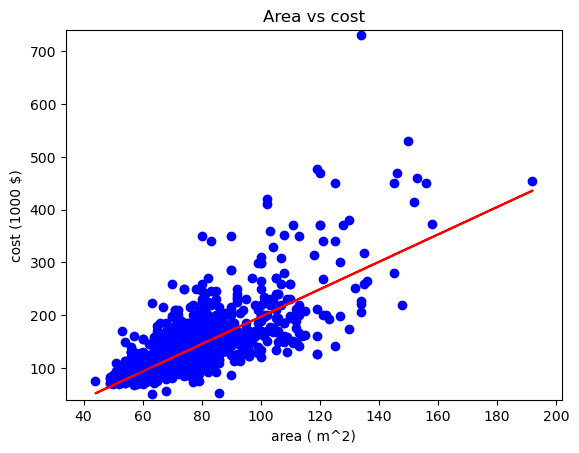

    cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0  2040  260093   260093.0 -62.044844  2.593462 -5.042011e-11  0.756042


In [145]:
# Experiment № 1
# Description: SLR with full dataset (positive relation)

SLR_solv.Experiment(count=1, full_dataset=True, random_sampling=False, positive=False, cnt_sample=0, viz_with_err=False)

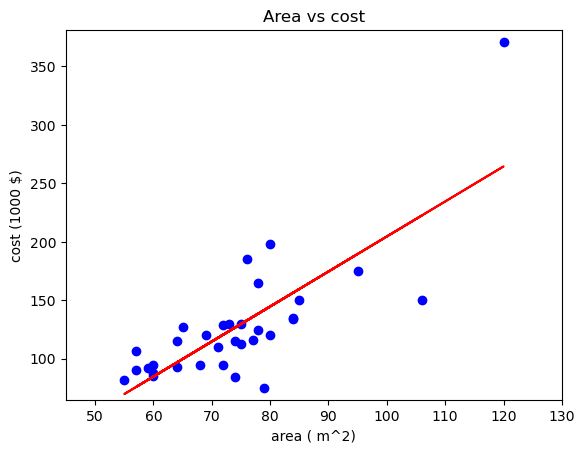

   cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0   33    4194     4194.0 -94.840471  2.994168  1.136868e-13  0.779017


In [146]:
# Experiment № 2
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0, viz_with_err=False)

Point 1: y_original=110, y_predict=133.24930727985893, error=-23.249307279858925
Point 2: y_original=185, y_predict=133.24930727985893, error=51.750692720141075
Point 3: y_original=75, y_predict=48.30123430134225, error=26.698765698657752
Point 4: y_original=140, y_predict=160.27823959120516, error=-20.278239591205164
Point 5: y_original=450, y_predict=411.26118248227715, error=38.73881751772285
Point 6: y_original=106, y_predict=113.94292705746878, error=-7.942927057468779
Point 7: y_original=209, y_predict=233.64248443628773, error=-24.64248443628773
Point 8: y_original=158, y_predict=191.16844794702936, error=-33.168447947029364
Point 9: y_original=95, y_predict=75.33016661268846, error=19.66983338731154
Point 10: y_original=92, y_predict=98.49782287955665, error=-6.497822879556651
Point 11: y_original=95, y_predict=75.33016661268846, error=19.66983338731154
Point 12: y_original=125, y_predict=140.97185936881496, error=-15.971859368814961
Point 13: y_original=82, y_predict=83.052718

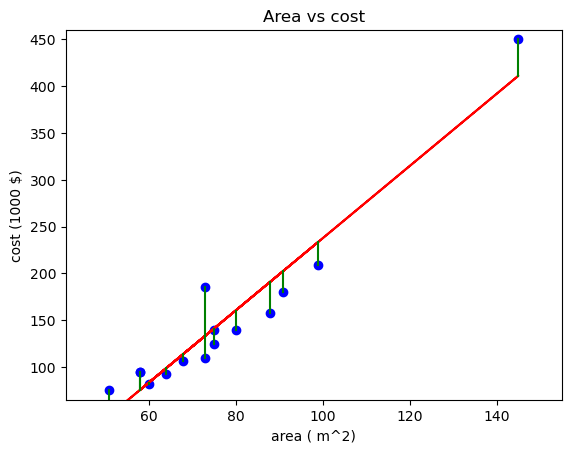

   cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0   15    2242     2242.0 -148.623844  3.861276  2.273737e-13  0.960778


In [147]:
# Experiment № 3
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=False, positive=False, cnt_sample=15,  viz_with_err=True)

In [148]:
# Experiment № 4
# Description: many SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=50, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0,  viz_with_err=False)

    cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0    44    5978     5978.0 -140.705764  3.848531 -1.733724e-12  0.918785
1    49    6182     6182.0  -73.672097  2.789724 -7.815970e-13  0.759797
2    98   11958    11958.0  -25.955505  2.053475 -1.847411e-13  0.670808
3    82    9667     9667.0   -3.627873  1.705371 -1.165290e-12  0.703523
4    62    8299     8299.0  -70.297289  2.766047  1.620037e-12  0.707723
5    61    8250     8250.0 -118.668642  3.448083  5.115908e-13  0.822068
6    30    4212     4212.0  -74.402233  2.845063 -2.842171e-13  0.636568
7    92   11069    11069.0  -17.534098  1.917759  2.302158e-12  0.656985
8    52    6392     6392.0  -30.090192  2.143505  4.973799e-13  0.787098
9    98   12078    12078.0  -50.059190  2.434953 -5.968559e-13  0.746311
10   35    4377     4377.0   -5.119424  1.808008  2.984279e-13  0.589027
11   62    8195     8195.0  -40.402065  2.351633  4.263256e-13  0.669846
12   59    7769     7769.0  -45.815583  2.396366  9